# Importing packages, setting seeds

In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
device

device(type='cuda', index=0)

# Loading and normalizing the data

In [3]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2112, 0.2086, 0.2121))
     ])

batch_size = 64

train_data = torchvision.datasets.CIFAR10(root="train/", train=True, 
                                          download=True, transform=transform)
# used_data = list(range(0, len(train_data), 10))
# train_data = torch.utils.data.Subset(train_data, used_data)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)
valid_data = torchvision.datasets.CIFAR10(root="test/", train=False, 
                                          download=True, transform=transform)
# used_data = list(range(0, len(valid_data), 2))
# valid_data = torch.utils.data.Subset(valid_data, used_data)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
img = next(iter(train_loader))[0][0]

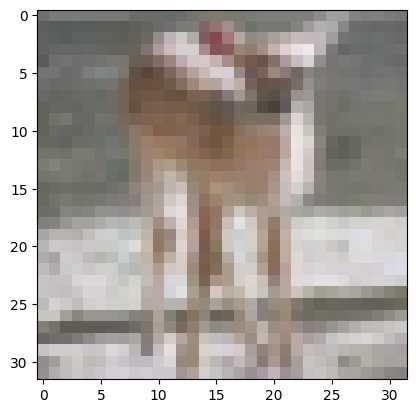

In [5]:
plt.imshow(np.transpose(img / 5 + 0.5, (1, 2, 0)))

# Адаптируем архитектуру Resnet34 для изображений 32x32

In [6]:
from resnet import ResNet34, BasicBlock

In [7]:
model = ResNet34(BasicBlock).to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
n_epochs = 10

In [13]:
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional import recall
from torchmetrics.functional import precision
from torchmetrics.functional import f1_score

writer = SummaryWriter(log_dir="runs/cifar10_resnet34")
best_loss = float("+Inf")

for epoch in range(n_epochs):
    train_loss = 0
    
    model.train()
    for train_batch_num, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    writer.add_scalar('loss/train', train_loss / len(train_loader), epoch)
    print("trained")

    model.eval()
    valid_recall, valid_precision, valid_f1_score, valid_loss = 0, 0, 0, 0
    
    for valid_batch_num, (images, labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output, labels)
        
        valid_loss += loss.item()
        valid_recall += recall(output, labels, "multiclass", num_classes=10, average="macro").item()
        valid_precision += precision(output, labels, "multiclass", num_classes=10, average="macro").item()
        valid_f1_score += f1_score(output, labels, "multiclass", num_classes=10, average="macro").item()
    
    if valid_loss < best_loss:
        torch.save(model, "best_model.pt")
        print("saving best model")
        best_loss = valid_loss
    
    writer.add_scalar('loss/valid', valid_loss / len(valid_loader), epoch)
    writer.add_scalar('metrics/recall', valid_recall / len(valid_loader), epoch)
    writer.add_scalar('metrics/precision', valid_precision / len(valid_loader), epoch)
    writer.add_scalar('metrics/f1_score', valid_f1_score / len(valid_loader), epoch)
    

writer.flush()

In [12]:
detailed_recall = [0] * 10
detailed_precision = [0] * 10
detailed_f1_score = [0] * 10

for valid_batch_num, (images, labels) in enumerate(valid_loader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    loss = loss_fn(output, labels)
    
    new_recall = recall(output, labels, "multiclass", num_classes=10, average=None).tolist()
    new_precision = precision(output, labels, "multiclass", num_classes=10, average=None).tolist()
    new_f1_score = f1_score(output, labels, "multiclass", num_classes=10, average=None).tolist()
    
    detailed_recall = [sum(x) for x in zip(detailed_recall, new_recall)]
    detailed_precision = [sum(x) for x in zip(detailed_precision, new_precision)]
    detailed_f1_score = [sum(x) for x in zip(detailed_f1_score, new_f1_score)]

detailed_recall = [el / len(valid_loader) for el in detailed_recall]
detailed_precision = [el / len(valid_loader) for el in detailed_precision]
detailed_f1_score = [el / len(valid_loader) for el in detailed_f1_score]

detailed_recall = {train_data.classes[i]: detailed_recall[i] for i in range(len(detailed_recall))}
detailed_precision = {train_data.classes[i]: detailed_precision[i] for i in range(len(detailed_precision))}
detailed_f1_score = {train_data.classes[i]: detailed_f1_score[i] for i in range(len(detailed_f1_score))}

In [14]:
writer = SummaryWriter(log_dir="runs/cifar10_resnet34")

for class_name in train_data.classes:
    writer.add_scalar(f"metrics/{class_name}_recall", detailed_recall[class_name])
    writer.add_scalar(f"metrics/{class_name}_precision", detailed_precision[class_name])
    writer.add_scalar(f"metrics/{class_name}_f1", detailed_f1_score[class_name])

writer.flush()
writer.close()